# topics:
- [Hough transform](#Hough-transform)
 - [Hough Line Transform doc](https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html)
- [Probabilistic-Hough-Transform](#Probabilistic-Hough-Transform)
   
- [lane Finder](#lane-Finder)
----
slide 5


In [1]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Hough transform 

In [2]:
img = cv2.imread('session_10/dave.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# find edge with some algorithm
# other algorhtims:
# https://github.com/bigmpc/cv-spring-2021/blob/main/notebooks/session_5.md
# laplacian = cv2.Laplacian(img,cv2.CV_64F)
# sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
# sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
# scharrx = cv2.Scharr(img,cv2.CV_64F,1,0)
# scharry = cv2.Scharr(img,cv2.CV_64F,0,1)
edges = cv2.Canny(gray,50,150,apertureSize = 3)

lines = cv2.HoughLines(edges,1,np.pi/180,120)


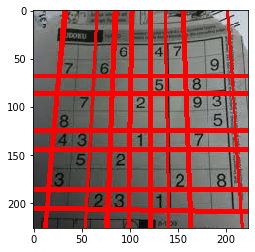

In [3]:

for i in range(0, len(lines)):
    for rho,theta in lines[i]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        
        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)




        
plt.imshow(img[:,:,::-1])
plt.show()

# Probabilistic Hough Transform

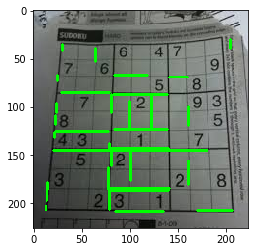

In [44]:
#probabilistic hough transform
img = cv2.imread('session_10/dave.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

lines = cv2.HoughLinesP(edges,1,np.pi/180,120,10,5)
for i in range(0, len(lines)):
    for x1,y1,x2,y2 in lines[i]:
        cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
plt.imshow(img[:,:,::-1])
plt.show()

# lane Finder
![lane-Finder](session_10/lane-Finder.png)

In [4]:

# preliminary attempt at lane following system
# largely derived from: https://medium.com/pharos-production/
# road-lane-recognition-with-opencv-and-ios-a892a3ab635c

# identify filename of video to be analyzed
cap = cv2.VideoCapture('session_10/testvideo2.mp4')

# read video frame & show on screen
ret, frame = cap.read()

# loop through until entire video file is played
while(ret):

    
    frame=cv2.resize(frame,(800,400))
    cv2.imshow("Original Scene", frame)


    # create polygon (trapezoid) mask to select region of interest
    mask = np.zeros((frame.shape[0], frame.shape[1]), dtype="uint8")
    pts = np.array([[80, 400], [330, 310], [450, 310], [750, 400]], dtype=np.int32)
    
    cv2.fillConvexPoly(mask, pts, 255)
    cv2.imshow("Mask", mask)

    # apply mask and show masked image on screen
    masked = cv2.bitwise_and(frame, frame, mask=mask)
    cv2.imshow("Region of Interest", masked)

    # convert to grayscale then black/white to binary image
    masked = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
    thresh = 200
    ret,masked = cv2.threshold(masked, thresh, 255, cv2.THRESH_BINARY)
    #cv2.imshow("Black/White", masked)


    
    # identify edges & show on screen
    edged = cv2.Canny(masked, 30, 150)
    #cv2.imshow("Edged", edged)

    # perform full Hough Transform to identify lane lines
    lines = cv2.HoughLines(edged, 1, np.pi / 180, 25)

    # define arrays for left and right lanes
    rho_left = []
    theta_left = []
    rho_right = []
    theta_right = []

    # ensure cv2.HoughLines found at least one line
    if lines is not None:

        # loop through all of the lines found by cv2.HoughLines
        for i in range(0, len(lines)):

            # evaluate each row of cv2.HoughLines output 'lines'
            for rho, theta in lines[i]:

                # collect left lanes
                if theta < np.pi/2 and theta > np.pi/4:
                    rho_left.append(rho)
                    theta_left.append(theta)

                     # plot all lane lines for DEMO PURPOSES ONLY
                    # a = np.cos(theta); b = np.sin(theta)
                    # x0 = a * rho; y0 = b * rho
                    # x1 = int(x0 + 400 * (-b)); y1 = int(y0 + 400 * (a))
                    # x2 = int(x0 - 600 * (-b)); y2 = int(y0 - 600 * (a))
                    #
                    # cv2.line(snip, (x1, y1), (x2, y2), (0, 0, 255), 1)

                # collect right lanes
                if theta > np.pi/2 and theta < 3*np.pi/4:
                    rho_right.append(rho)
                    theta_right.append(theta)

                    # # plot all lane lines for DEMO PURPOSES ONLY
                    # a = np.cos(theta); b = np.sin(theta)
                    # x0 = a * rho; y0 = b * rho
                    # x1 = int(x0 + 400 * (-b)); y1 = int(y0 + 400 * (a))
                    # x2 = int(x0 - 600 * (-b)); y2 = int(y0 - 600 * (a))
                    #
                    # cv2.line(snip, (x1, y1), (x2, y2), (0, 0, 255), 1)

    # statistics to identify median lane dimensions
    left_rho = np.median(rho_left)
    left_theta = np.median(theta_left)
    right_rho = np.median(rho_right)
    right_theta = np.median(theta_right)

    # plot median lane on top of scene snip
    if left_theta > np.pi/4:
        a = np.cos(left_theta); b = np.sin(left_theta)
        x0 = a * left_rho; y0 = b * left_rho
        offset1 = 200; offset2 = 500
        x1 = int(x0 - offset1 * (-b)); y1 = int(y0 - offset1 * (a))
        x2 = int(x0 + offset2 * (-b)); y2 = int(y0 + offset2 * (a))

        cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 6)

    if right_theta > np.pi/4:
        a = np.cos(right_theta); b = np.sin(right_theta)
        x0 = a * right_rho; y0 = b * right_rho
        offset1 = 500; offset2 = 800
        x3 = int(x0 - offset1 * (-b)); y3 = int(y0 - offset1 * (a))
        x4 = int(x0 - offset2 * (-b)); y4 = int(y0 - offset2 * (a))

        cv2.line(frame, (x3, y3), (x4, y4), (255, 0, 0), 6)



    cv2.imshow("Lined", frame)


    # press the q key to break out of video
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

    # read video frame & show on screen
    ret, frame = cap.read()
    
# clear everything once finished
cap.release()
cv2.destroyAllWindows()

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
